In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlalchemy, pyodbc, os

In [45]:
# Original .csv file has no id column, so create one that has an id column and load it into a DataFrame.
df_original = pd.read_csv(r'..\Data_Set\gun_deaths.csv', index_col=False)
df_original.to_csv(r'..\Data_Set\gun_deaths_index.csv', index_label='id')
df_original = pd.read_csv(r'..\Data_Set\gun_deaths_index.csv', index_col=False)

## Connect to MSSQL Database

In [46]:
print(pyodbc.drivers())

['SQL Server', 'SQL Server Native Client RDA 11.0', 'ODBC Driver 17 for SQL Server']


In [47]:
# Create connection to SQL Server database
connection_string = f'mssql+pyodbc://{os.environ.get("SQL_AUTH")}/Gun_Deaths?driver=ODBC+Driver+17+for+SQL+Server'
engine = sqlalchemy.create_engine(connection_string)
conn = engine.connect()

# Examine and clean the data.

In [48]:
print(df_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100798 entries, 0 to 100797
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         100798 non-null  int64  
 1   year       100798 non-null  int64  
 2   month      100798 non-null  int64  
 3   intent     100797 non-null  object 
 4   police     100798 non-null  int64  
 5   sex        100798 non-null  object 
 6   age        100780 non-null  float64
 7   race       100798 non-null  object 
 8   place      99414 non-null   object 
 9   education  99376 non-null   object 
dtypes: float64(1), int64(4), object(5)
memory usage: 7.7+ MB
None



The data cleaning will be done with SQL in the 'SQL_Queries' folder.
* intent, age, place, and education have null/missing values, they will be handled in the SQL folder.
* A .csv file from the cleaning is produced and will be used to explore the data further with a data frame object.

## Read the clean data into a new dataframe and explore the data.

In [49]:
df_clean = pd.read_csv(r'..\Data_Set\gun_deaths_clean.csv')
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100798 entries, 0 to 100797
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         100798 non-null  int64 
 1   year       100798 non-null  int64 
 2   month      100798 non-null  int64 
 3   intent     100798 non-null  object
 4   police     100798 non-null  int64 
 5   sex        100798 non-null  object
 6   age        100798 non-null  int64 
 7   race       100798 non-null  object
 8   place      100798 non-null  object
 9   education  100798 non-null  object
dtypes: int64(5), object(5)
memory usage: 7.7+ MB


## This dataset contains data for years 2012 through 2014. Lets analyse the count of deaths through the years.

In [50]:
# To make a line graph showing a time series, it will be necessary to combine the month and year columns into a date column.
dates = df_clean['year'].astype('string') + '-' + df_clean['month'].astype('string')
df_clean['date'] = pd.to_datetime(dates)

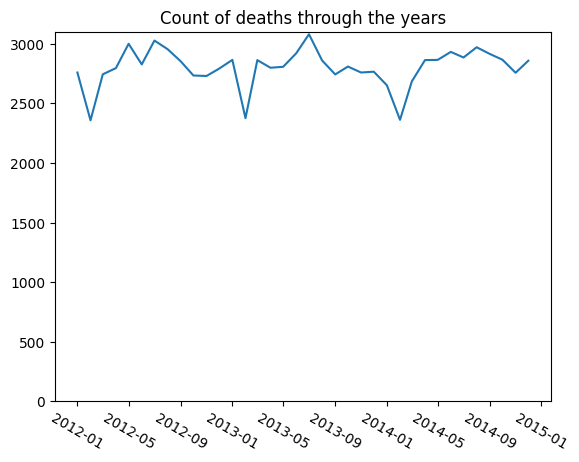

In [51]:
deaths_timeseries = df_clean.groupby('date')['id'].count()
plt.plot(df_clean['date'].unique(), deaths_timeseries)
plt.xticks(rotation=-30)
plt.ylim((0, 3100))
plt.title('Count of deaths through the years')
plt.show()

## Find distribution of intent.

In [52]:
sql_query = """
SELECT
    intent,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY intent
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,intent,count_deaths
0,Suicide,63176
1,Homicide,35176
2,Accidental,1639
3,Undetermined,807


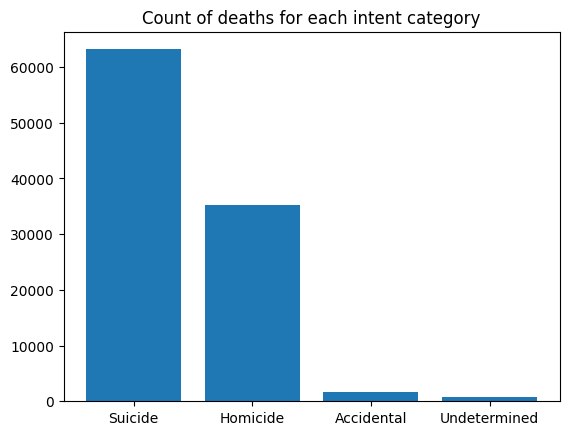

In [53]:
plt.bar(query_df['intent'], query_df['count_deaths'])
plt.title('Count of deaths for each intent category')
plt.show()

### Explore the racial disparities for each intent.

In [54]:
sql_query = """
WITH agg AS (
    SELECT
        race,
        intent,
        COUNT(*) AS count_deaths
    FROM dbo.gun_deaths
    GROUP BY race, intent
)
SELECT
    race,
    COALESCE(intent, 'Total') AS intent,
    count_deaths
FROM agg
ORDER BY 1 ASC;   
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,race,intent,count_deaths
0,Asian/Pacific Islander,Homicide,559
1,Asian/Pacific Islander,Undetermined,10
2,Asian/Pacific Islander,Accidental,12
3,Asian/Pacific Islander,Suicide,745
4,Black,Accidental,328
5,Black,Suicide,3332
6,Black,Homicide,19510
7,Black,Undetermined,126
8,Hispanic,Homicide,5634
9,Hispanic,Suicide,3171


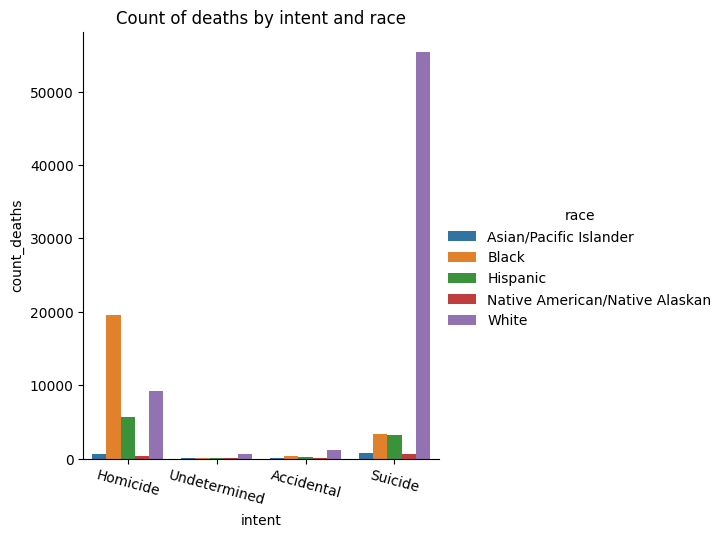

In [55]:
# Visualize with a grouped bar chart.
sns.catplot(x='intent', y='count_deaths',
            data=query_df,
            hue='race',
            kind='bar')
plt.title('Count of deaths by intent and race')
plt.xticks(rotation=-15)
plt.show()

### Is there any correlation between where the death takes place and the intent?

In [56]:
sql_query = """
SELECT
    place,
    intent,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
WHERE place IN ('Home', 'Street')
GROUP BY place, intent
ORDER BY 1 ASC, 2 ASC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,place,intent,count_deaths
0,Home,Accidental,923
1,Home,Homicide,13613
2,Home,Suicide,45415
3,Home,Undetermined,535
4,Street,Accidental,78
5,Street,Homicide,8867
6,Street,Suicide,2181
7,Street,Undetermined,25


### Explore gender and education of the gun victims.

In [57]:
sql_query = """
SELECT
    sex,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY sex
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,sex,count_deaths
0,M,86349
1,F,14449


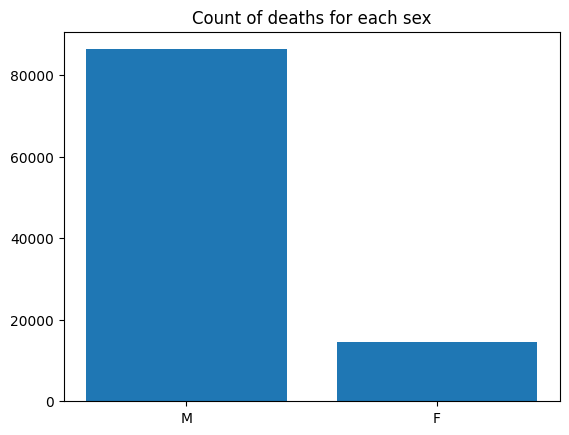

In [58]:
plt.bar(query_df['sex'], query_df['count_deaths'])
plt.title('Count of deaths for each sex')
plt.show()

In [59]:
sql_query = """
SELECT
    education,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY education
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,education,count_deaths
0,HS/GED,42927
1,Less than HS,21823
2,Some college,21680
3,BA+,12946
4,Other,1422


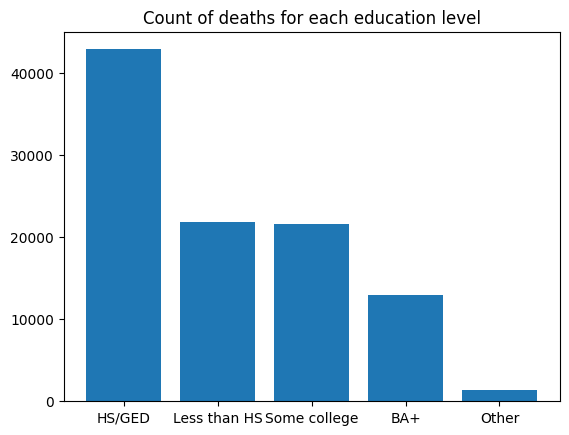

In [60]:
plt.bar(query_df['education'], query_df['count_deaths'])
plt.title('Count of deaths for each education level')
plt.show()

### Explore age of the victims

In [61]:
df_clean['age'].describe()

count    100798.000000
mean         43.857448
std          19.494443
min           0.000000
25%          27.000000
50%          42.000000
75%          58.000000
max         107.000000
Name: age, dtype: float64

In [62]:
print('Median: ' + str(df_clean['age'].median()))
print('Mode:   ' + str(df_clean['age'].mode()[0]))

Median: 42.0
Mode:   22


In [63]:
# Produce a table that categorizes the age ranges into minor(0-17), young adult(18-39), middle adult(40-64), and elderly(65+)
sql_query = """
SELECT 
    CASE WHEN age <= 17 THEN 'minor'
    WHEN age >= 18 AND age <= 39 THEN 'young adult'
    WHEN age >= 40 AND age <= 64 THEN 'middle adult'
    WHEN age >= 65 THEN 'elderly'
    END AS age_group,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
GROUP BY
    CASE WHEN age <= 17 THEN 'minor'
    WHEN age >= 18 AND age <= 39 THEN 'young adult'
    WHEN age >= 40 AND age <= 64 THEN 'middle adult'
    WHEN age >= 65 THEN 'elderly'
    END;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,age_group,count_deaths
0,young adult,43082
1,middle adult,37118
2,elderly,16708
3,minor,3890


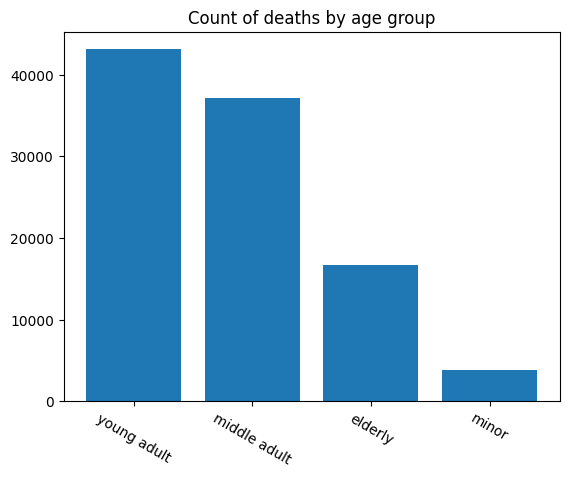

In [64]:
plt.bar(query_df['age_group'], query_df['count_deaths'])
plt.title('Count of deaths by age group')
plt.xticks(rotation=-30)
plt.show()

In [65]:
# To visualize age groups in greater detail, lets create a histogram with the bin size to be about ten years.
sql_query = """
WITH bins_start AS (
    SELECT 
        ROW_NUMBER() OVER(ORDER BY value) as rownum,
        value
    FROM GENERATE_SERIES(0, 110, 10)
),
bins_stop AS (
    SELECT
        ROW_NUMBER() OVER(ORDER BY value) as rownum, 
        value
    FROM GENERATE_SERIES(9, 110, 10)
),
bins AS (
    SELECT
        a.value AS age_start_bin,
        b.value AS age_stop_bin
    FROM bins_start a
    JOIN bins_stop b ON a.rownum = b.rownum
)
SELECT 
    CASE WHEN b.age_start_bin = 0 THEN '0-9'
        WHEN b.age_start_bin = 10 THEN '10-19'
        WHEN b.age_start_bin = 20 THEN '20-29'
        WHEN b.age_start_bin = 30 THEN '30-39'
        WHEN b.age_start_bin = 40 THEN '40-49'
        WHEN b.age_start_bin = 50 THEN '50-59'
        WHEN b.age_start_bin = 60 THEN '60-69'
        WHEN b.age_start_bin = 70 THEN '70-79'
        WHEN b.age_start_bin = 80 THEN '80-89'
        WHEN b.age_start_bin = 90 THEN '90-99'
        WHEN b.age_start_bin = 100 THEN '100-109'
    END AS age_bin,
    COUNT(gd.age) AS count_deaths
FROM dbo.gun_deaths AS gd
JOIN bins AS b
    ON gd.age >= b.age_start_bin
    AND gd.age <= b.age_stop_bin
GROUP BY
    b.age_start_bin,
    b.age_stop_bin;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
query_df

,age_bin,count_deaths
0,0-9,456
1,10-19,7252
2,20-29,22816
3,30-39,16448
4,40-49,15016
5,50-59,16169
6,60-69,10582
7,70-79,6822
8,80-89,4415
9,90-99,816


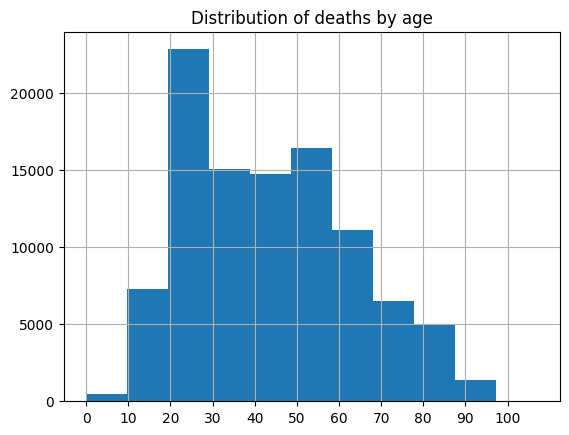

In [66]:
df_clean.hist(column='age', bins= 11)
plt.title('Distribution of deaths by age')
plt.xticks(ticks=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.show()

### Lets explore the young adult age group (18-39) to extract further insights

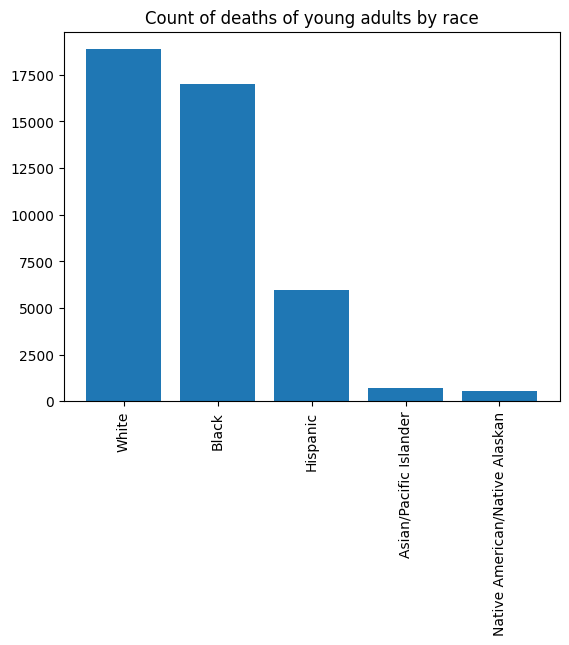

In [67]:
sql_query = """
SELECT
    race,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
WHERE age >= 18 AND age <= 39
GROUP BY race
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
plt.bar(query_df['race'], query_df['count_deaths'])
plt.title('Count of deaths of young adults by race')
plt.xticks(rotation=90)
plt.show()

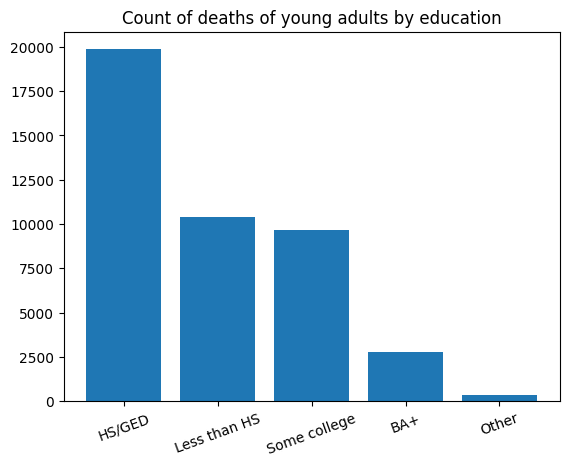

In [68]:
sql_query = """
SELECT
    education,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
WHERE age >= 18 AND age <= 39
GROUP BY education
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
plt.bar(query_df['education'], query_df['count_deaths'])
plt.title('Count of deaths of young adults by education')
plt.xticks(rotation=20)
plt.show()

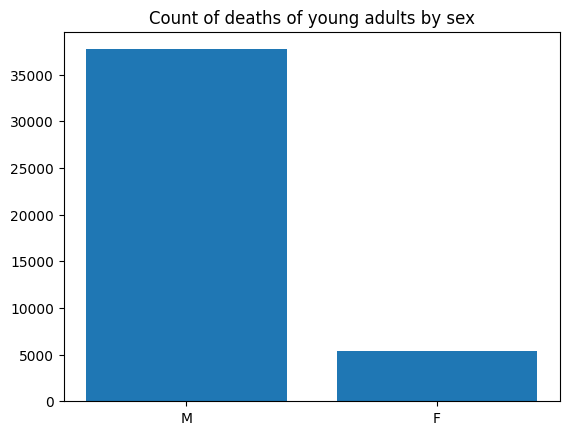

In [69]:
sql_query = """
SELECT
    sex,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
WHERE age >= 18 AND age <= 39
GROUP BY sex
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
plt.bar(query_df['sex'], query_df['count_deaths'])
plt.title('Count of deaths of young adults by sex')
plt.show()

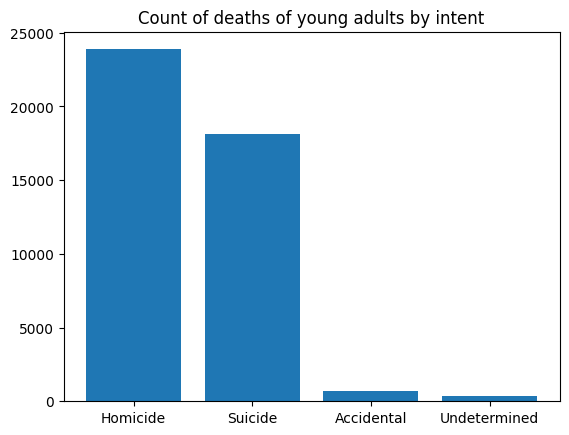

In [70]:
sql_query = """
SELECT
    intent,
    COUNT(*) AS count_deaths
FROM dbo.gun_deaths
WHERE age >= 18 AND age <= 39
GROUP BY intent
ORDER BY 2 DESC;
"""
query_df = pd.read_sql(sql=sql_query, con=conn)
plt.bar(query_df['intent'], query_df['count_deaths'])
plt.title('Count of deaths of young adults by intent')
plt.show()

# Summary of findings
* Through the years, 2013 has the highest number of gun related deaths, though there is not a high number of difference between each year.
* The count of deaths is lowest in Feburary of each year.
* Overall, white people account for most of the deaths in this dataset.
* Among the categories of intent, suicide has the highest count of deaths.
    * Within the suicide intent, white people make up most of the deaths.
    * Within the homicide intent, black people make up most of the deaths.
* Among the different age groups, young adults (18-39) account for most gun-related deaths.
    * Also among the young adults age group, whites still have the highest count of deaths, although blacks are a close second.
    * Middle adults (40-64) make up the second highest deaths, though still far more deaths than elderly and minors.
* Among the different levels of education, people with highschool level or GED level education make up most of the deaths.
    * This makes sense when one considers that young adults across all races have the most deaths among the age groups.
* There are far more male deaths than female deaths.
* The highest number of deaths inside homes are suicides.
* The highest number of deaths on the streets are homicides.


### From these findings, there is a high number of suicides from young white men. Young black men are most often the victim of homicides.